# Community detection  - workshop modularity optimization

In this workshop we will consider the problem of community detection using the **modularity optimization method**. The idea behind this method is that any community detection algorithm yields a partition of the nodes of the graph $V$ into different (say $m$) sets $C_1, \dots, C_m$. Here each set is then supposed to resemble a community. Of course, there are many different ways to partition $V$ into $m$ subsets, representing different communities. This becomes even more when we do not fix the number $m$ of partitions. In the end, the question of community detection then boils down to: *which partition is the best one?*

One way of deciding this is to assign a score to each partition $C_1, \dots, C_m$ and then pick the partition with the best (often highest) score. But then we need to decide how to assign a score to a partition. 

*IMPORTANT: load data using the function `read_multiline_adjlist`*

## Modularity score

*Modularity* is simply one way of assigning a score to a community assignment of a graph. The main idea behind *modularity* is to compare the presence of an edge between two nodes in the same community with the probability that they would be connected is their edge would form in a given *null model*. The idea behind this score is that links between nodes in the same community should be more likely than based on the *null model*. And a good partition is one that maximizes this score.

The standard choice is to pick the *Configuration model* here. That is, for two nodes $i$ and $j$ the probability that they are connected is given by

$$\frac{d_i d_j}{2|E|}$$.

In the end modularity simply compares this number to the indicator of and egde $A_{ij}$ whenever both nodes are in the same community $C$ and takes the avereage over all edges. This results in the followin formula

$$Q(G) = \frac{1}{2|E|} \sum_{i,j = 1}^n \left(A_{ij} - \frac{d_i d_j}{2|E|}\right) \delta(C(i), C(j)),$$

where $C(i)$ is the community to which $i$ belongs and $\delta(x,y)$ is the delta-function ($1$ if $x=y$ and $0$ else).

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path
import random

**Exercise 1.** Load the graph 'graph_with_communities_3.gz' and consider the following two partitions of the vertex set $V = \{0,1, \dots, 179\}$:

1. $C_1 = \{i \in V : i < 100\}$ and $C_2 = \{i \in V : i \ge 100\}$,
2. $C_1 = \{i \in V : i \text{ is even}\}$ and $C_2 = \{i \in V : i \text{ is odd}\}$.

For each partition compute the modularity score. Which of the two has the highest score? If you draw the graph, does the partition with the highest score make sense from the prespective of community detection and why?

In [1]:
### Your solution goes here

## Modularity maximization - Louvain algorithm

In the previous exercise you where give two different community assignments and asked to see which is better using the modularity score. However, in practice you would have to check all possible partitions and find the one with the highest score. This seems like a terrible exercise. And it is! Finding a partition that maximizes modularity is known to be a very difficult problem (NP-hard is that mean anything to you). 

Luckily there exists a very nice local algorithm that tries to find a partition with a close-to-optimal modularity score. This is the so-called Louvain algorithm. The first step is to generalize the modularity score to graphs with non-negative edge weights. Let $W_{ij}$ be the weight of the edge $(i,j)$ and write $s_i = \sum_{j = 1}^n W_{ij}$ to denote the *strenght* of node $i$ and $W_n = \sum_{i = 1}^n s_i$ the total strenght of all nodes. Note that if $W_{ij} = A_{ij}$ then $s_i = d_i$ and $W_n = 2|E_n|$.

The new modularity score is then given by

$$Q(G) = \frac{1}{W_n} \sum_{i,j = 1}^n \left(W_{ij} - \frac{s_i s_j}{W_n}\right) \delta(C(i), C(j)).$$

The Louvain algorithm now works as follows. First each node is assigned to its own community. Then the algorithm does two steps:

    1. Select a node, look at the community of its neighbors and see if adding this node to that community increases 
    modularity. If so, then add the node to this community. Go to the next node (selected at random from all available 
    nodes) and repeat until all nodes have been visited.
    2. Create a new network, where each community is a (super) node and two nodes are connected if there is at least 
    one edge between the communities which is given a weight corresponding to the total number of edges between the 
    communities. Go to step 1.
    
If at some point no more improvement in modularity score is gained the algorithm outputs the communities (with the original nodes of the the graph).

Luckily, you do not have to implement this algorithm yourself. You can use the `louvain_communities` function from the NetworX library. Alternatively, you can use `louvain_partitions` to also obtain the partitions at each stage of the algorithm in addition to the final partition.

Below is a utility function that applies Louvain to a graph `G`, gives each community a different color and draws the resulting graph.

In [103]:
# Function that runs Louvain community detection and plots the resulting graph
# with communities labeled by different colors

def FindandShowCommunities(G,pos=None,resolution=1,seed=123):
    
    # Run Louvain to get the communities
    C = nx.community.louvain_communities(G,resolution=resolution,seed=seed)

    number_communities = len(C)

    # Next we create color for the different communities
    # We cycle through all rgb values [0,1] in an equal number of steps 
    # and use a modulo 2 operation to jump between either adding red or 
    # green to create contrast between community colors
    colors = []
    node_colors = {}
    for c in range(0,number_communities):
        r = 1-(c % 2)*(c/number_communities)
        g = 1-((c+1) % 2)*(c/number_communities)
        b = (c%2)*(c/number_communities)
        colors.append((r,g,b))
        community_members = C[c]
        for node in community_members:
            node_colors[node]=(r,g,b)

    n = G.number_of_nodes()
    
    # Assing group colors to the nodes    
    group_colors = []

    for i in range(0,n):
        node_color = node_colors[i]
        group_colors.append(node_color)

    # Draw the graph.
    fig = plt.figure(figsize=(50,50))
    nx.draw_networkx(G,pos=pos,node_color=group_colors,node_size=1000)
    
    return C

**Exercise 2.** Run the Louvain algorithm on the graph 'graph_with_communities_3.gz' from the previous exercise using `seed = 123`. Draw the graph and give nodes of communities different colors. What communities does the algorithm find? How do these relate to the two communities you considered in Exercise 1? 

In [ ]:
# Your answer goes here

The graph `graph_with_communities_3.gz` was created using a SBM with $N = \{100,80\}$ and $$P = \begin{pmatrix}
\frac{5}{100} &  \frac{1}{100} \\
   \frac{1}{100} & \frac{5}{80}
\end{pmatrix}.$$
So the communities should be $C_1 = \{0,1,\dots, 99\}$ and $C_2 = \{100,101,\dots,179\}$.

**Exercise 3.** Did the Louvain algoritm find the *right* communities? If not, what could be the reason for this?

In [ ]:
# Your answer goes here

**Exercise 4.** Write code to generate SBM graphs with two communities $C_1, C_2$ of equal size $n$ and given (potentially different) average degrees inside the community $\lambda_1, \lambda_2$. In addition, set the probability for inter-community connections at $1/(10n)$.

Now experiment with different values of $\lambda_i$ and $n$ and see when Louvain returns the *right* communities. What pattern do you observe? Is there a relationship between the parameters and the correct outcome of Louvain?

In [ ]:
# Your answer goes here

It should become clear at this point that even when the graphs are created to have a clear community structure, modularity optimizaion might not yield the expected result.

## Resolution limit

There is, however, an even more pressing problem with modularity. To illustrate this we have created the code below to generat a graph that consists of several small complete graphs that are linked to form a chain.

In [47]:
# Code to create a graph to where modularity behaves unexpectedly 

def ResolutionLimitGraph(c,k):
    
    # Creates a collection of complete graphs linked in a circular pattern by a single edge
    # c: Number of clique groups (each group consists of two complete graphs)
    # k: The size of the complete graphs
    
    # Total number of cliques is twice the number of groups
    m = 2*c
    
    # Total number of nodes
    n = k*m

    # Initialize the graph
    resolution_graph = nx.Graph()
    
    # Create m complete graphs and join them into one graph
    for i in range(0,m):
        K = nx.complete_graph(k)
        resolution_graph = nx.disjoint_union(resolution_graph,K)

    # Connect the different complete graphs by one link
    for i in range(0,m):
        v = (i+1)*k-1
        w = (i+1)*k % n
        resolution_graph.add_edge(v,w)

    return resolution_graph

Here is an example of this kind of graph where we have $20$ complete graphs of size $4$.

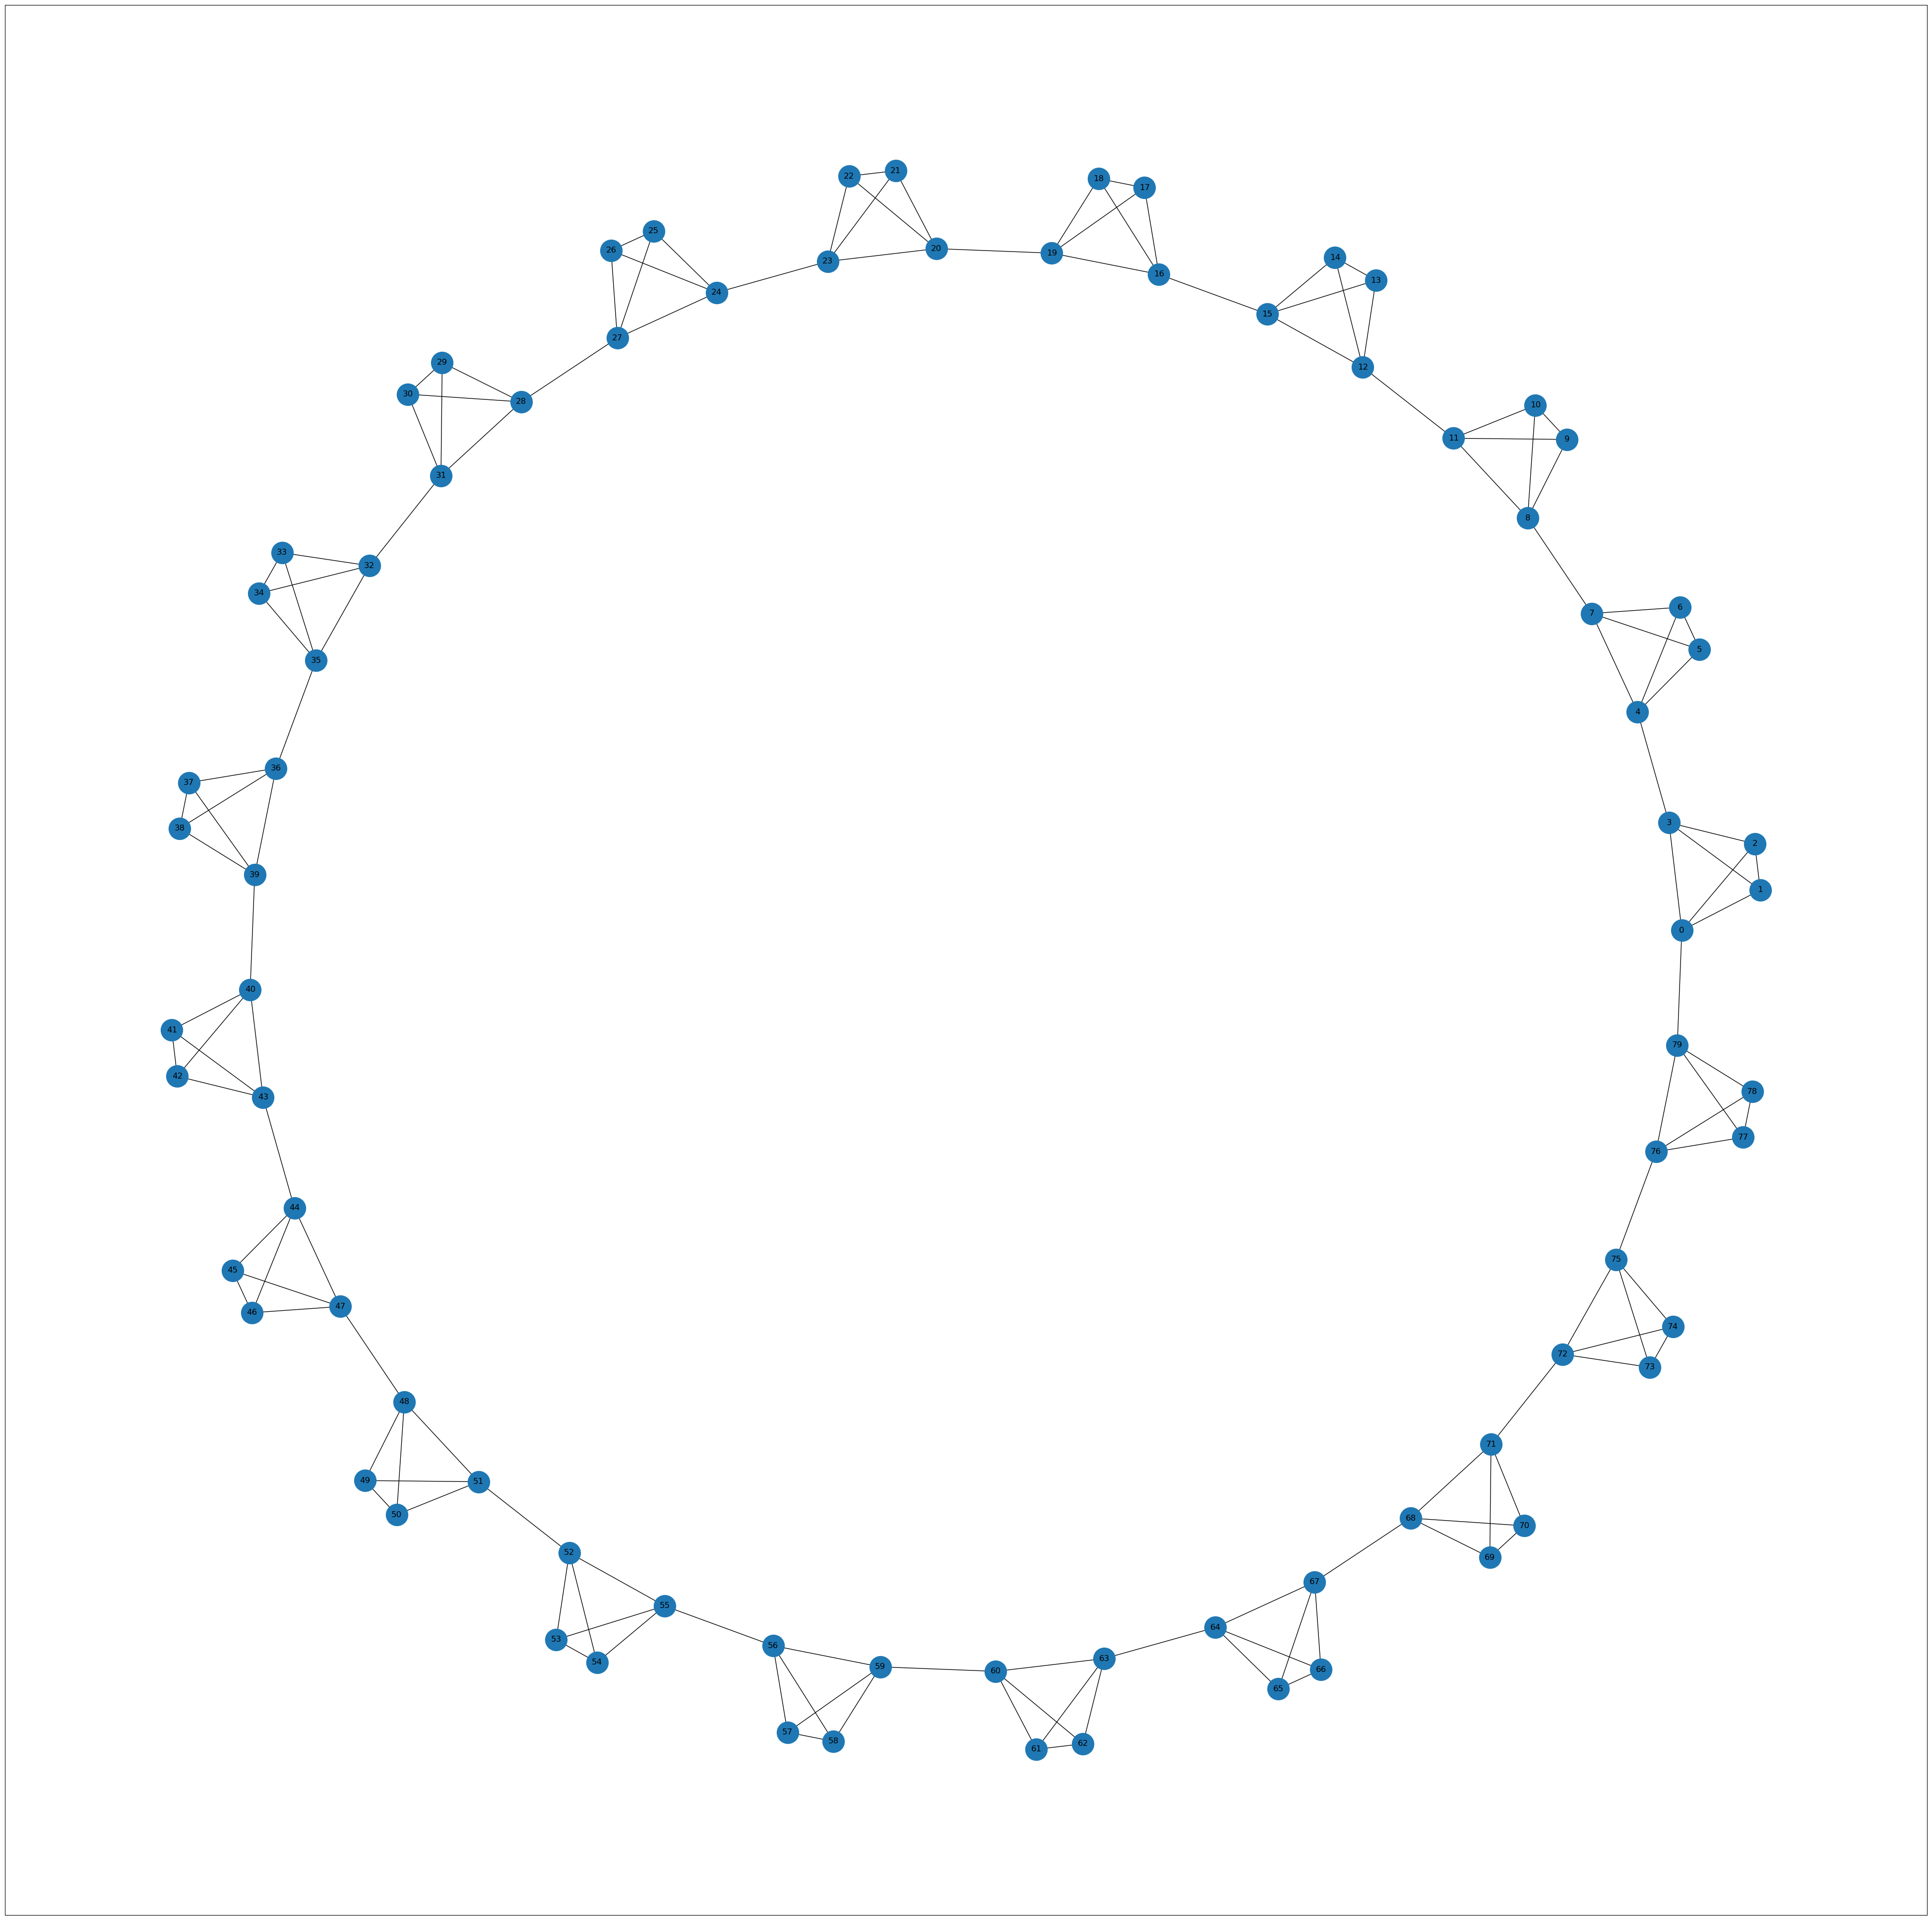

In [48]:
resolution_graph = ResolutionLimitGraph(10,4)
    
fig = plt.figure(figsize=(50,50))

nx.draw_networkx(resolution_graph,pos=nx.kamada_kawai_layout(resolution_graph),node_size=1000)

When looking at the graph one can imagine that each complete graph is its own community. Thus, modularity optimization should yield $20$ communities on this graph. However, if we run the Louvain algorithm we get the following result:

Found 10 communities where 20 where expected.


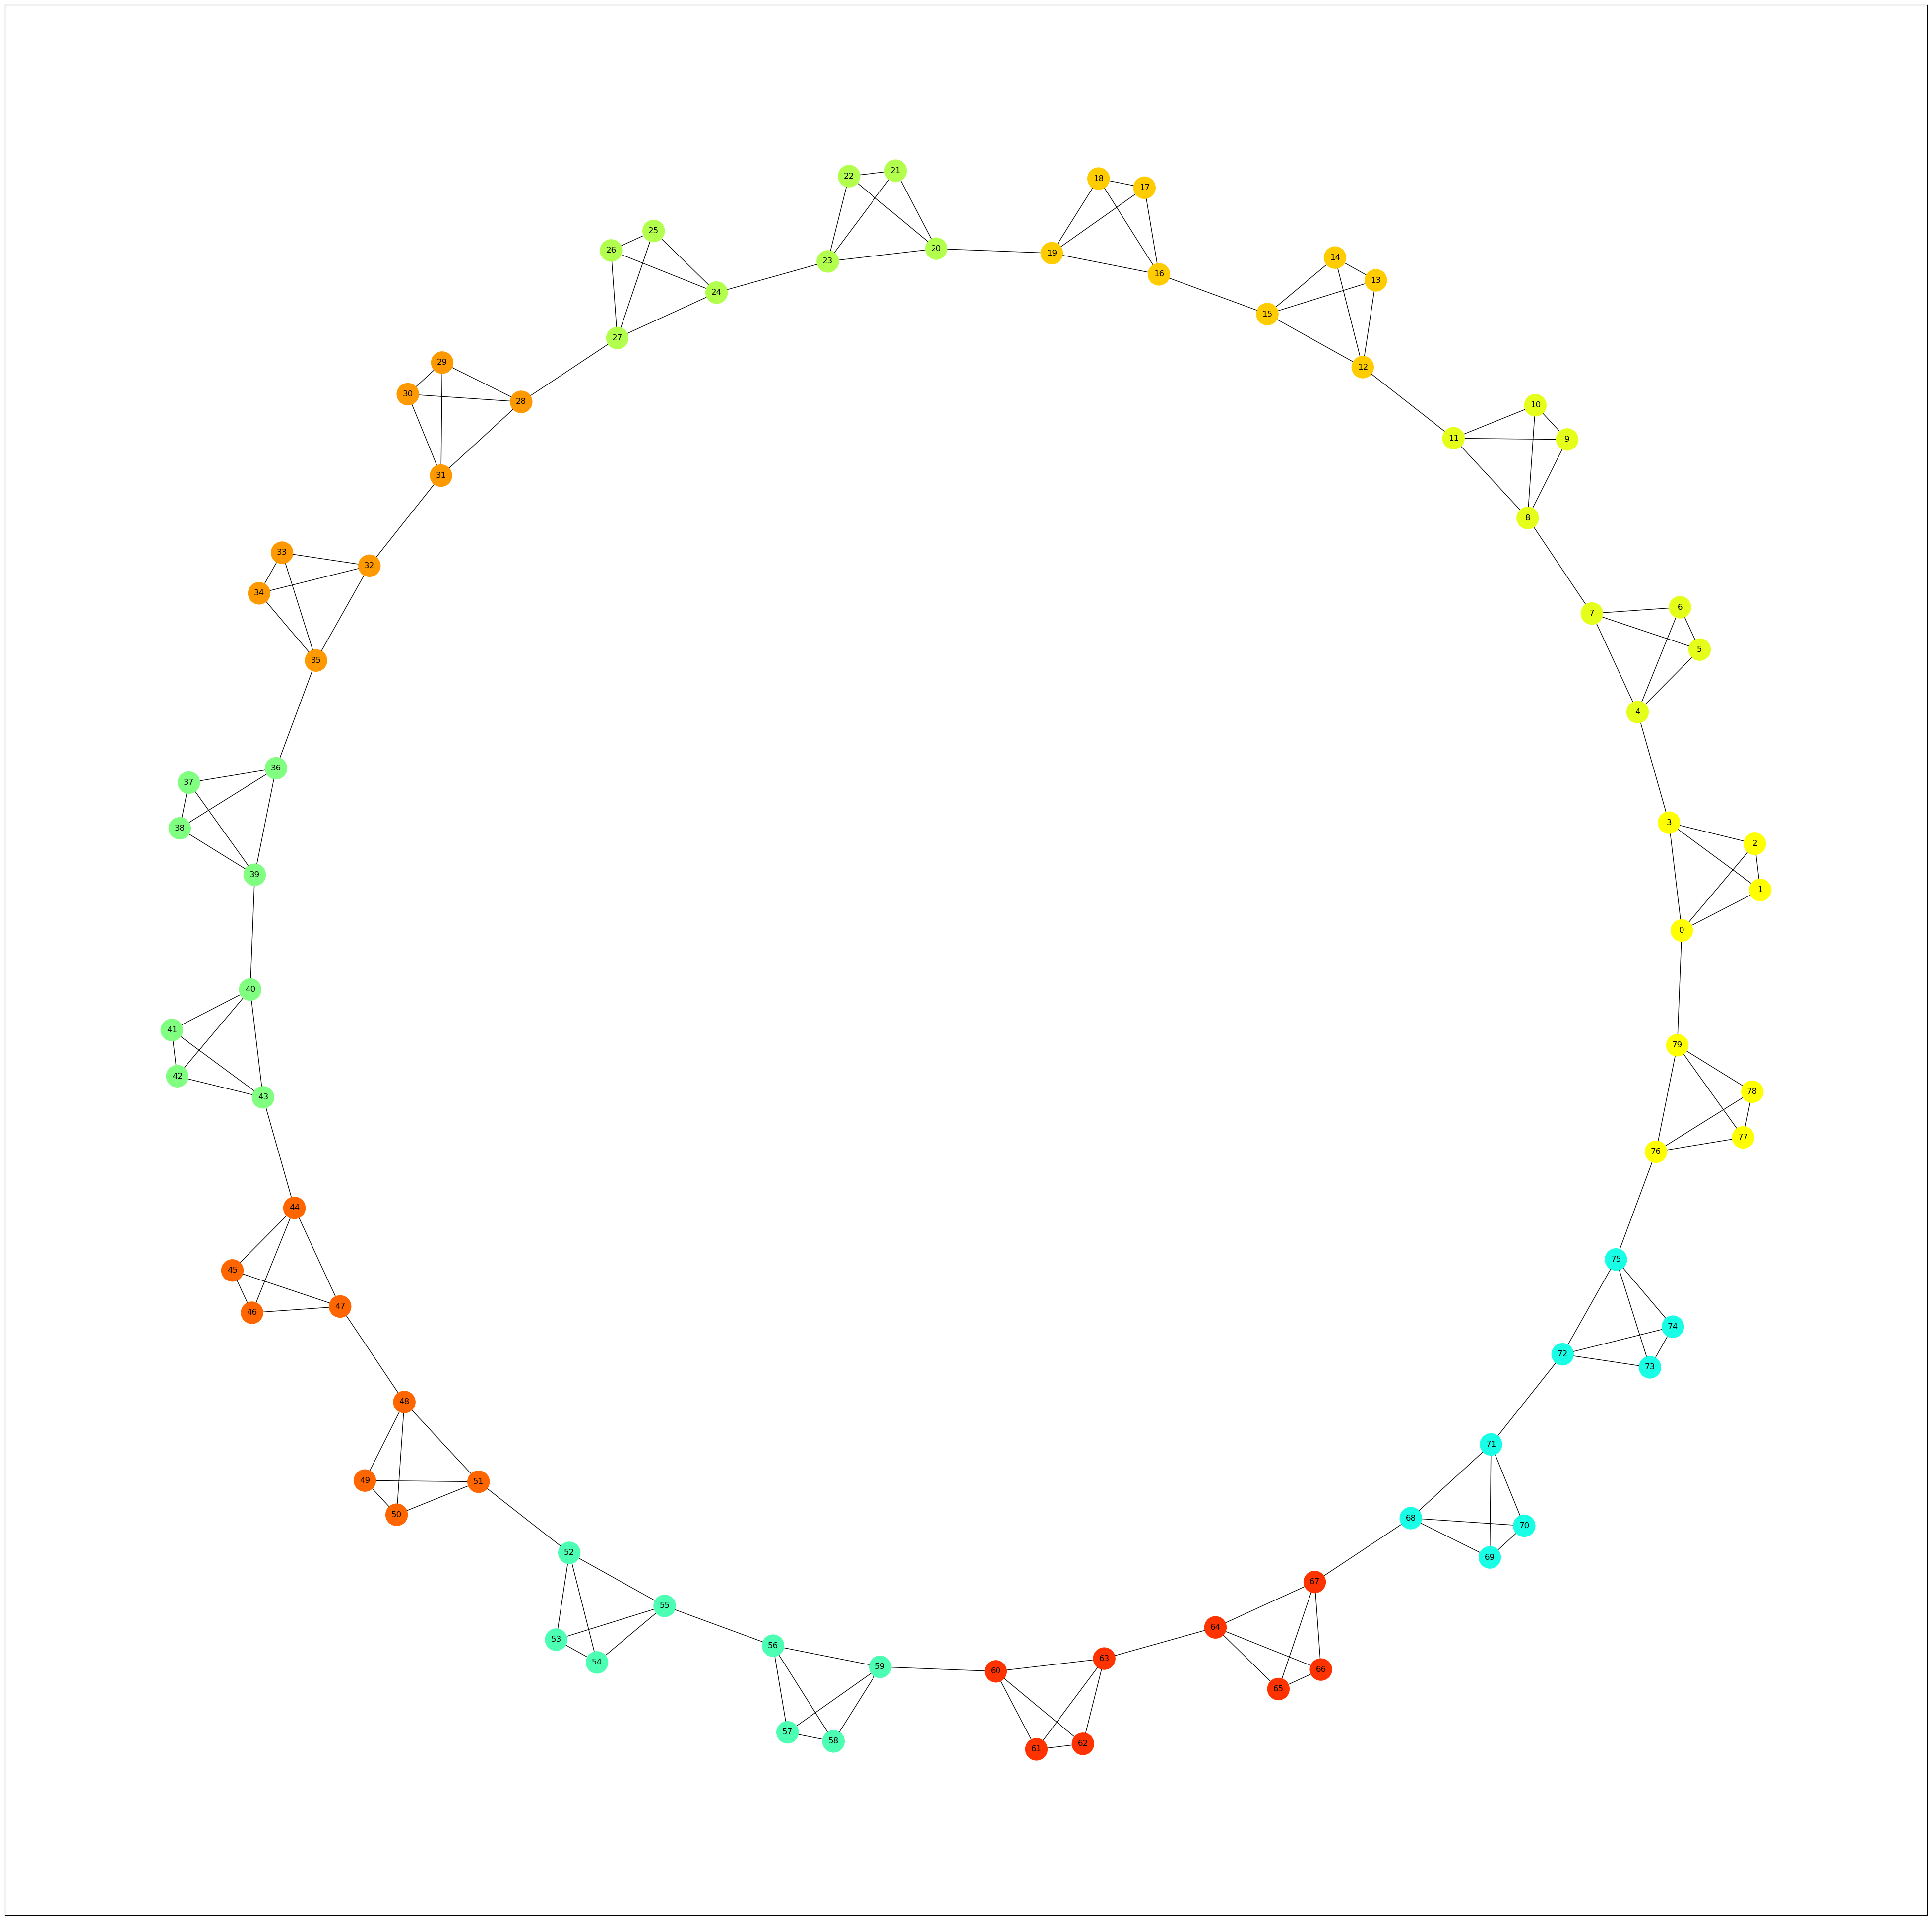

In [104]:
C =FindandShowCommunities(resolution_graph,pos=nx.kamada_kawai_layout(resolution_graph))
print(f"Found {len(C)} communities where 20 where expected.")

For some inexplicable reason, it seems that modularity is optimized by merging two adjacent complete graphs together. This means there are two optimal community assignments, one where we pair the complete graphs to the ones on their right and the other with graphs to their left. That does not makes much sense.

The problem that is at play here is called the *resolution limit*. In short, the modulatiy score prefers communities of a particular size over smaller communities. In the example above this size is $8$, rather than $4$. 

See *Fortunato, Santo, and Marc Barthelemy. "Resolution limit in community detection." Proceedings of the national academy of sciences 104.1 (2007): 36-41.* for more details on this problem.

**Exercise 5.** Run Louvain on graphs generated by `ResolutionLimitGraph` for different choices of `c` and `k`. When does the resolution limit problem arise? Can you distinguish a pattern?

In [ ]:
# Your answer goes here

One way to deal with this resolution limit is to add a parameter $\gamma \in (0,\infty)$ to the *null model* term in the modularity score. That is,

$$Q(G) = \frac{1}{W_n} \sum_{i,j = 1}^n \left(W_{ij} - {\color{red} \gamma} \frac{s_i s_j}{W_n}\right) \delta(C(i), C(j)).$$

This is implemented as well in the NetworkX functions via the `resolution` parameter.

**Exercise 6.** Run the Louvain algorithm on the `ResolutionLimitGraph(c,k)` with `c=10` and `k=4` for different values of `resolution`. How does the change in resolution affect the outcome? When do you get the expected answer?

In [105]:
# Your answer goes here

To further explore the impact of resolution we will consider $d$-regular graphs. These are simpy *Configuration Model* graphs where all nodes have the same degree $d$. The NetworkX library has a function `random_regular_graph` for this.

**Exercise 7.** Create a regular graph with $d = 5$ of size 500 and run Louvain with different values of resolution. What do you observe? When do you only get one community?

In [ ]:
# Your answer goes here

**Exercise 8.** Now do the same thing for graphs consisting of two $d$-regular graphs of size $100$ with possibly different values for $d$ that are connected by picking `cx` edges randomly between them for `cx = 10, 100`. For which value of the resolution do you obtain the two graphs as communities? How does this depend on the degrees and the edges between the graphs?

In [116]:
# Your answer goes here